This notebook is an example of a prediction of an inverse-designed three-channel MDM (de)multiplexer by [Masnad et al.](https://doi.org/10.1364/PSC.2021.Tu4A.4) Recall that the current prediction model is for a 220 nm SOI e-beam process. This example demonstrates:
1. Loading a prediction model
2. Preparing a device gds for prediction
3. Running a prediction
4. Analyzing a prediction

In [161]:
import matplotlib.pyplot as plt

import sys
sys.path.append('../')

from prefab.predictor import Predictor
from prefab.processor import *
from prefab.io import *

%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


First, let's load the predictor model in. Models are named (and loaded) by specifying the type ('p' for predictor), the fab facility, the process name, the version of the model, and the number of the model. Multiple model numbers can be loaded at the same time to create an ensemble that produces more accurate predictions.

In [162]:
predictor = Predictor(type='p', fab='ANT', process='NanoSOI', version='v0.1', model_nums=[0,1,2,3])

Second, we load a device layout (.gds) in as a matrix with values between 0 and 1. An inverse-designed (de)multiplexer is used here, but you can try the other devices in the `/devices` folder, or add your own!

We must specify the resolution of the images that the model was trained on (in nm/px), the length of the image slicing used in training (in px), and the length of the device loaded in (in nm).

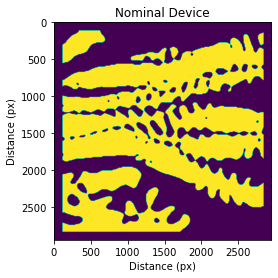

In [164]:
res = 1.6548 # nm/px
slice_length = 128 # px
device_length = 4500 # nm

device = load_device_gds(path='../devices/demux.gds', cell_name='demux',
    slice_length=slice_length, device_length=device_length, res=res)
    
plt.imshow(device)
plt.title('Nominal Device')
plt.ylabel('Distance (px)')
plt.xlabel('Distance (px)')
plt.show()

Third, we're ready to make the prediction. We must specify the step length, which determines how fine the prediction is. A small step length will produce nice predictions, but may require significant memory resources for large devices.

We should also specify if we want a binarized output. By default, the predictor outputs the raw prediction, which shows the "fuzzy" areas of the structure that will vary from fab to fab, device to device. If we choose to binarize, the predictor will output the most likely outcome. We can also binarize after the prediction so we have both to view.

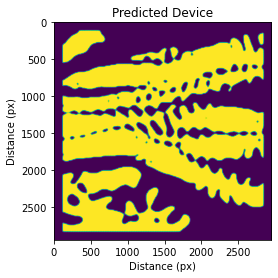

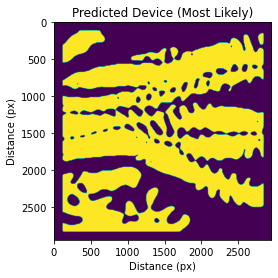

In [165]:
step_length = 32
prediction = predictor.predict(device=device, step_length=step_length, binary=False)

plt.imshow(prediction)
plt.title('Predicted Device')
plt.ylabel('Distance (px)')
plt.xlabel('Distance (px)')
plt.show()

plt.imshow(binarize(prediction))
plt.title('Predicted Device (Most Likely)')
plt.ylabel('Distance (px)')
plt.xlabel('Distance (px)')
plt.show()

Lastly, let's do some analysis of the prediction we just made. The first analysis we'll do is to plot the possible variations between the nominal device and the prediction. From this plot, we see that the ridges of the device are highly likely to be rounded, with some degree of uncertainty as to where exactly the edges will be (no process is perfect!).

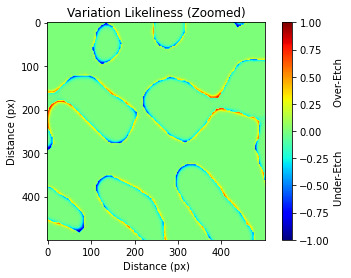

In [166]:
variation = device - prediction

plt.imshow(variation[1000:1500, 1000:1500], cmap='jet', vmin=-1, vmax=1)
plt.title('Variation Likeliness (Zoomed)')
plt.ylabel('Distance (px)')
plt.xlabel('Distance (px)')
cb = plt.colorbar()
cb.set_label('Under-Etch              Over-Etch')
plt.show()

Another way we can represent these results is to highlight where the edge is most likely to be (i.e., where the predictor is most uncertain on if the pixel is silicon or silica). The bright line of this plot is where the edge is most likely to be, but in reality, there is a range of possible locations. For finer features (e.g., the narrow channel in the plot below at x = 200, y = 170), we see that uncertainty is increased and the range of possible edge positions is larger! This channel may be bridged for some runs and remain open for others. This is a sign that we want to avoid using these types of features for our device if possible.

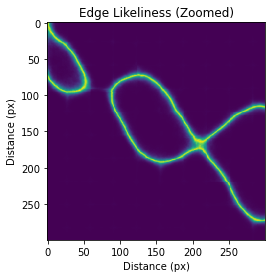

In [167]:
uncertainty = 1 - 2*np.abs(0.5 - prediction)

plt.imshow(uncertainty[1700:2000, 1700:2000])
plt.title('Edge Likeliness (Zoomed)')
plt.ylabel('Distance (px)')
plt.xlabel('Distance (px)')
plt.show()

And that's it! From here, you can take the prediction and simulate the expected performance or try to make corrections to your design to minimize variation and uncertainty.

We can now export the prediction to `/gds/prefab_example_demux.gds`.

In [168]:
lib = gdspy.GdsLibrary()
gdspy.current_library = gdspy.GdsLibrary()

device_name = 'demux'
cell = lib.new_cell(device_name)
cell.add(dev2cell(library=lib, device=device, res=res, cell_name=device_name+'_nominal'))
cell.add(dev2cell(library=lib, device=binarize(prediction), res=res, cell_name=device_name+'_prediction', layer=9))
lib.write_gds('../gds/prefab_example_demux.gds')